# Fit simple Milky Way disk rotation model to FGKM golden sample

This notebook repeats the modelling of the Milky Way rotation curve in section 10.1 of the paper _Gaia Data Release 3: A Golden Sample of Astrophysical Parameters_ by [Gaia Collaboration, Creevey et al. (2022)]() for the FGKM golden sample.

First query the Gaia DR3 archive for the data necessary to reproduce the analysis and store in the `../data` folder.

```sql
select fgkm.*, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, 
gaia.pmra_error, gaia.pmdec_error, gaia.parallax_error,
gaia.pmra_pmdec_corr, gaia.parallax_pmra_corr, gaia.parallax_pmdec_corr,
gaia.radial_velocity, gaia.radial_velocity_error, gaia.rv_template_teff, gaia.grvs_mag,
gaia.phot_g_mean_mag, gaia.bp_rp, gaia.bp_g, gaia.g_rp, ap.abp_gspphot, ap.arp_gspphot
from gaiadr3.gaia_source as gaia
join gaiadr3.gold_sample_fgkm_stars as fgkm
using (source_id)
join gaiadr3.astrophysical_parameters as ap
using (source_id)
```

The modelling steps below are the same as for the OBA star sample in [this notebook](FitMWDiskKinModel.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

## Read in data

In [ ]:
Rsun = 8.277*u.kpc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

## Several versions of HR diagram

In [ ]:
fig=plt.figure(constrained_layout=True, figsize=(2*6,2*6))

gs = GridSpec(2, 2, figure=fig)

axplxsnr = fig.add_subplot(gs[0,0])
apply_tufte(axplxsnr)

axplxsnr.hist(fgkmtable['parallax_over_error'], bins='auto', histtype='step', lw=2)
axplxsnr.set_xscale('log')
axplxsnr.set_xlabel(r'$\varpi/\sigma_\varpi$')
axplxsnr.set_ylabel('N')

axkiel = fig.add_subplot(gs[0,1])
apply_tufte(axkiel)
axkiel.hexbin(np.log10(fgkmtable['teff_gspphot']), fgkmtable['logg_gspphot'], bins='log', gridsize=200, mincnt=1)
axkiel.set_xlabel(r'$\log T_\mathrm{eff}$ [K]')
axkiel.set_ylabel(r'$\log g$ [cm s$^{-2}$]')
axkiel.invert_xaxis()
axkiel.invert_yaxis()
, gridsize=200
axhrd = fig.add_subplot(gs[1,0])
apply_tufte(axhrd)
axhrd.hexbin(np.log10(fgkmtable['teff_gspphot']), np.log10(fgkmtable['lum_flame']), bins='log', gridsize=200, mincnt=1)
axhrd.set_xlabel(r'$\log T_\mathrm{eff}$ [K]')
axhrd.set_ylabel(r'$\log(L/L_\odot)$')
axhrd.invert_xaxis()

axcmd = fig.add_subplot(gs[1,1])
apply_tufte(axcmd)
axcmd.hexbin(fgkmtable['bp_rp0_gspphot'], fgkmtable['mg_abs0_gspphot'], bins='log', gridsize=200, mincnt=1)
axcmd.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})_0$')
axcmd.set_ylabel(r'$M_{G,0}$')
axcmd.invert_yaxis()

plt.show()

## Select subsample

In [ ]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

spt_lum_filter = giants

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

# Not yet how I first implemented it:
filter_of_choice = "giants"

# spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)
#



subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(16.5,10), tight_layout=True)

gs = fig.add_gridspec(2, 3, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)
ax_rvphi = fig.add_subplot(gs[0,2])
apply_tufte(ax_rvphi)
ax_xy_vphi = fig.add_subplot(gs[1,0])
apply_tufte(ax_xy_vphi)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

hasrvs = sample_filter & fgkmtable['rvvalid']
ax_rvphi.hexbin(fgkmtable['R_gc'][hasrvs]/1000, fgkmtable['v_phi_gc'][hasrvs], mincnt=1, bins='log', extent=[0,15,0,400])
ax_rvphi.set_xlabel(r'$R$ [kpc]') 
ax_rvphi.set_ylabel(r'$v_\phi$ [km s$^{-1}$]')

ax_xy_vphi.hexbin(fgkmtable['x_gc'][hasrvs]/1000, fgkmtable['y_gc'][hasrvs]/1000, mincnt=0, C=fgkmtable['v_phi_gc'][hasrvs],
                  reduce_C_function=np.median, bins='log', extent=plotgrid)
ax_xy_vphi.set_xlabel(r'$X$ [kpc]') 
ax_xy_vphi.set_ylabel(r'$Y$ [kpc]') 

plt.show()

## Plot histogram of $\sin(b)\times 1000/\varpi$

Use this to estimate $Z_\odot$ for this sample.

In [ ]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

## Plot the sample proper motions as a function of galactic longitude

In [ ]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

plt.savefig('fgkmstar-pml-pmb-vs-galon.png')

plt.show()

## Set up the Stan model

In [ ]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun':zsun.value
            }
with open('fgkm.data.json', 'w') as fp:
    ujson.dump(fgkm_data, fp)
    fp.close()
    
bp2010_model_giants = {'stanfile':'mwdisk-bp2010-model-giants.stan', 
               'npars':12,
               'parnames':['Vcirc_sun', 'hbp', 'pbp', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_r', 'amplitude_phi', 'amplitude_z', 'R_scale_r', 'R_scale_phi', 'R_scale_z'],
               'labels':[r'$V_{\mathrm{circ},\odot}}$', r'$h$', r'$p$', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$A_{\sigma_{R}}$', r'$A_{\sigma_{\phi}}$', r'$A_{\sigma_{z}}$', r'$R_{\sigma_{R}}$', r'$R_{\sigma_{\phi}}$', r'$R_{\sigma_{z}}$'], 
               'inits':{'Vcirc_sun':220.0, 'hbp':4.0, 'pbp':0.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'amplitude_r':80.0, 'amplitude_phi':80.0, 'amplitude_z':80.0, 'R_scale_r':5, 'R_scale_phi':5, 'R_scale_z':5},
               'best_params':{'Vcirc_sun':np.nan, 'hbp':np.nan, 'pbp':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 
                              'amplitude_r':np.nan, 'amplitude_phi':np.nan, 'amplitude_z':np.nan, 'R_scale_r:':np.nan, 'R_scale_phi':np.nan, 'R_scale_z':np.nan}
              }

stan_model = bp2010_model_giants

## Sample posterior

Feed the FGKM star proper motion and parallax data to the Stan model and sample the posterior for the Milky Way parameters.

In [18]:
fgkm_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
set_cmdstan_path(os.path.join('C:/Users/rjrri/.cmdstan/', 'cmdstan-2.31.0'))
fgkm_data_path = os.path.join(os.getcwd(), 'fgkm.data.json')

nwarmup = 500
nsampling = 1000
nchains = 4

fgkm_model = CmdStanModel(stan_file=fgkm_stan)
fgkm_fit = fgkm_model.sample(chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=fgkm_data_path, save_warmup=False, show_progress='notebook', 
                             output_dir=fit_save_location)
#fgkm_fit = fgkm_model.sample(chains=4, inits=stan_model['inits'], iter_warmup=500, iter_sampling=1000, thin=1, 
#                           data=fgkm_data_path, save_warmup=False, show_progress='notebook')

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:Removing C:\Users\rjrri\DOCUME~1\UNIVER~1\FIRSTP~1\MILKYW~2\mwdisk-bp2010-model-giants.exe
16:29:19 - cmdstanpy - INFO - compiling stan file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\mwdisk-bp2010-model-giants.stan to exe file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\mwdisk-bp2010-model-giants.exe
INFO:cmdstanpy:compiling stan file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\mwdisk-bp2010-model-giants.stan to exe file C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\mwdisk-bp2010-model-giants.exe
DEBUG:cmdstanpy:cmd: mingw32-make C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-bp2010-model-giants.exe
cwd: C:\Users\rjrri\.cmdstan\cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bi

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\mwdisk-bp2010-model-giants.exe', 'id=1', 'random', 'seed=3458', 'data', 'file=C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fgkm.data.json', 'output', 'file=C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\mwdisk-bp2010-model-giants-20230611162949_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'thin=1', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\mwdisk-bp2010-model-giants.exe', 'id=2', 'random', 'seed=3458', 'data

16:39:59 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\mwdisk-bp2010-model-giants.exe', 'id=1', 'random', 'seed=3458', 'data', 'file=C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fgkm.data.json', 'output', 'file=C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\mwdisk-bp2010-model-giants-20230611162949_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=500', 'thin=1', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\mwdisk-bp2010-model-giants-20230611162949_1.csv
 console_msgs (if any):
	C:\Us

16:39:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: mwdisk_bp2010_model_giants_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-bp2010-model-giants.stan', line 199, column 2 to column 21)
	Exception: mwdisk_bp2010_model_giants_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-bp2010-model-giants.stan', line 199, column 2 to column 21)
	Exception: mwdisk_bp2010_model_giants_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-bp2010-model-giants.stan', line 199, column 2 to column 21)
	Exception: mwdisk_bp2010_model_giants_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk

Exception: mwdisk_bp2010_model_giants_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-bp2010-model-giants.stan', line 199, column 2 to column 21)
	Exception: mwdisk_bp2010_model_giants_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-bp2010-model-giants.stan', line 199, column 2 to column 21)
	Exception: mwdisk_bp2010_model_giants_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-bp2010-model-giants.stan', line 199, column 2 to column 21)
	Exception: mwdisk_bp2010_model_giants_model_namespace::log_prob: scov is not symmetric. scov[1,2] = nan, but scov[2,1] = nan (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/mwdisk-bp2010-model-giants.stan', line 199, column 2 to column 21)
	Exce

16:40:22 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 873 divergent transitions (87.3%)
	Chain 2 had 571 divergent transitions (57.1%)
	Chain 3 had 903 divergent transitions (90.3%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.
	Chain 1 had 873 divergent transitions (87.3%)
	Chain 2 had 571 divergent transitions (57.1%)
	Chain 3 had 903 divergent transitions (90.3%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use function "diagnose()" to see further information.


In [18]:
print(fgkm_fit.diagnose())

Processing csv files: C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\mwdisk-bp2010-model-20230609152357_1.csv, C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\mwdisk-bp2010-model-20230609152357_2.csv, C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\mwdisk-bp2010-model-20230609152357_3.csv, C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants\mwdisk-bp2010-model-20230609152357_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [31]:
# From Brown's github
fgkm_fit.summary()[0:stan_model['npars']+1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-8182.490000,0.055273,2.056590,-8186.190000,-8182.22000,-8179.680000,1384.420,0.649881,1.00131
Vcirc_sun,231.127000,0.147479,3.489940,225.060000,231.19300,236.695000,559.981,0.262868,1.00695
hbp,4.489510,0.033488,0.425565,3.654400,4.55864,5.063580,161.491,0.075808,1.01027
pbp,-0.799196,0.011664,0.141842,-0.980814,-0.82482,-0.524458,147.873,0.069415,1.01273
Vsun_pec_x,13.523500,0.022063,1.006380,11.858800,13.52000,15.155900,2080.680,0.976720,1.00302
Vsun_pec_y,27.037300,0.034117,1.373190,24.831400,27.03630,29.276100,1620.010,0.760472,1.00057
Vsun_pec_z,8.287450,0.015427,0.391901,7.649510,8.27255,8.947060,645.351,0.302943,1.00540
vdispR,39.746600,0.019208,0.744815,38.536700,39.72340,41.002200,1503.640,0.705842,1.00524
vdispPhi,29.551700,0.016979,0.801208,28.217300,29.54720,30.872200,2226.680,1.045260,1.00292
vdispZ,21.277700,0.007589,0.283643,20.817800,21.27390,21.754000,1397.020,0.655794,1.00274


In [19]:
# My replicated results
fgkm_fit.summary()[0:stan_model['npars']+1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-8100.68000,0.055697,2.199350,-8104.680000,-8100.360000,-8097.730000,1559.26,0.270938,1.002450
Vcirc_sun,225.17200,0.065204,3.535640,219.479000,225.170000,231.074000,2940.23,0.510897,1.000700
hbp,4.51227,0.015539,0.580642,3.418290,4.575810,5.317050,1396.32,0.242627,1.000470
pbp,-0.69354,0.004717,0.184902,-0.964874,-0.708771,-0.356941,1536.68,0.267015,0.999971
Vsun_pec_x,13.20610,0.016301,1.020050,11.502700,13.202400,14.876600,3915.59,0.680376,0.999967
Vsun_pec_y,26.70770,0.026347,1.391070,24.440600,26.712200,28.988700,2787.58,0.484373,1.000110
Vsun_pec_z,9.11899,0.006634,0.386249,8.486150,9.120970,9.762820,3390.09,0.589065,0.999990
vdispR,39.26170,0.013042,0.764679,38.014600,39.253900,40.544800,3437.58,0.597318,1.000910
vdispPhi,29.08150,0.014663,0.789426,27.787000,29.074700,30.402800,2898.65,0.503672,1.000960
vdispZ,20.77050,0.004438,0.276649,20.322700,20.770400,21.242300,3885.22,0.675100,0.999647


In [14]:
# My new results with vdisp formulas added
fgkm_fit.summary()[0:stan_model['npars']+1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1.487320e+08,8.045370e+07,1.139510e+08,-2.681420e+08,-7.102810e+07,-4.314470e+06,2.00608,0.001265,342.7770
Vcirc_sun,4.419860e+00,2.846640e+00,4.079180e+00,5.891240e-01,3.127700e+00,1.207250e+01,2.05343,0.001295,12.2554
hbp,2.633850e+00,1.458660e+00,2.065950e+00,2.139930e-01,3.078290e+00,5.750350e+00,2.00602,0.001265,39337.2000
pbp,6.337700e-01,5.245070e-01,7.428800e-01,-4.944450e-01,1.295880e+00,1.306990e+00,2.00602,0.001265,9860.6600
Vsun_pec_x,2.528630e+00,3.181470e+00,4.506040e+00,-1.580390e+00,1.384560e+00,1.011600e+01,2.00602,0.001265,21143.7000
Vsun_pec_y,1.108420e+01,1.172190e+01,1.660220e+01,9.181710e-01,1.994110e+00,3.983060e+01,2.00602,0.001265,16552.3000
Vsun_pec_z,4.240950e+00,4.824580e+00,6.833430e+00,-1.390790e+00,1.315520e+00,1.603670e+01,2.00613,0.001265,236.8340
amplitude_r,4.546180e+00,1.036900e+00,1.468610e+00,2.571310e+00,5.775020e+00,6.106120e+00,2.00604,0.001265,476.3150
amplitude_phi,7.065520e+00,8.248510e+00,1.168270e+01,2.097850e-01,3.959330e-01,2.732860e+01,2.00602,0.001265,1765.2900
amplitude_z,4.338590e+00,2.139280e+00,3.029950e+00,2.064400e-01,6.961180e+00,7.507640e+00,2.00602,0.001265,1533.2600


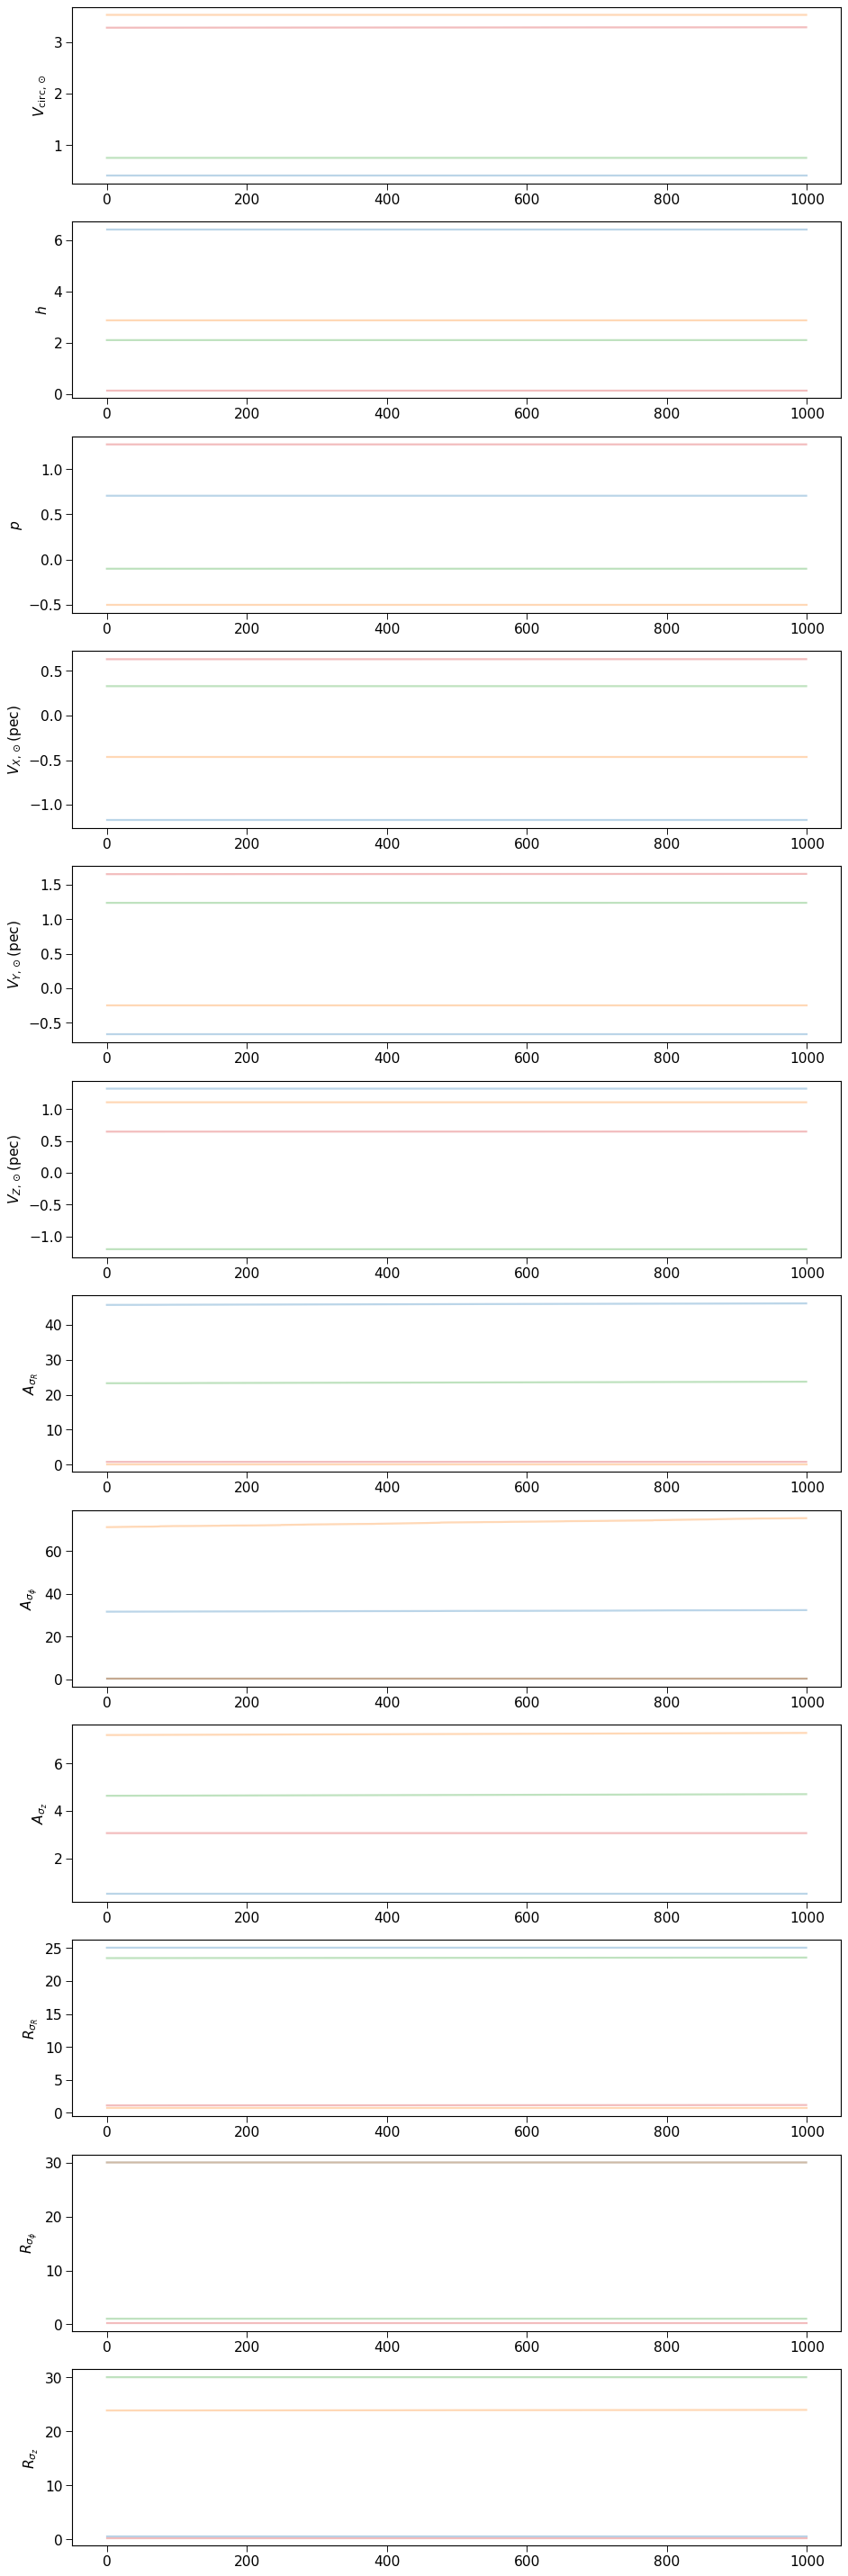

In [19]:
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

fig, axes = plt.subplots(ncols=1, nrows=stan_model['npars'], tight_layout=True, figsize=(12,3*stan_model['npars']))

for i, lab in zip(range(stan_model['npars']), stan_model['labels']):
    axes[i].plot(fgkm_fit.draws()[:,:,7+i], alpha=0.3)
    axes[i].set_ylabel(lab)

plt.show()

Vcirc_sun = 2.0+1.5-1.6
hbp = 2.5+3.9-2.3
pbp = 0.3+1.0-0.8
Vsun_pec_x = -0.1+0.7-1.1
Vsun_pec_y = 0.5+1.2-1.2
Vsun_pec_z = 0.9+0.4-2.1
amplitude_r = 12.0+33.8-11.9
amplitude_phi = 16.0+56.6-15.7
amplitude_z = 3.9+3.4-3.3
R_scale_r = 12.3+12.7-11.7
R_scale_phi = 15.5+14.5-15.3
R_scale_z = 12.2+17.8-11.9


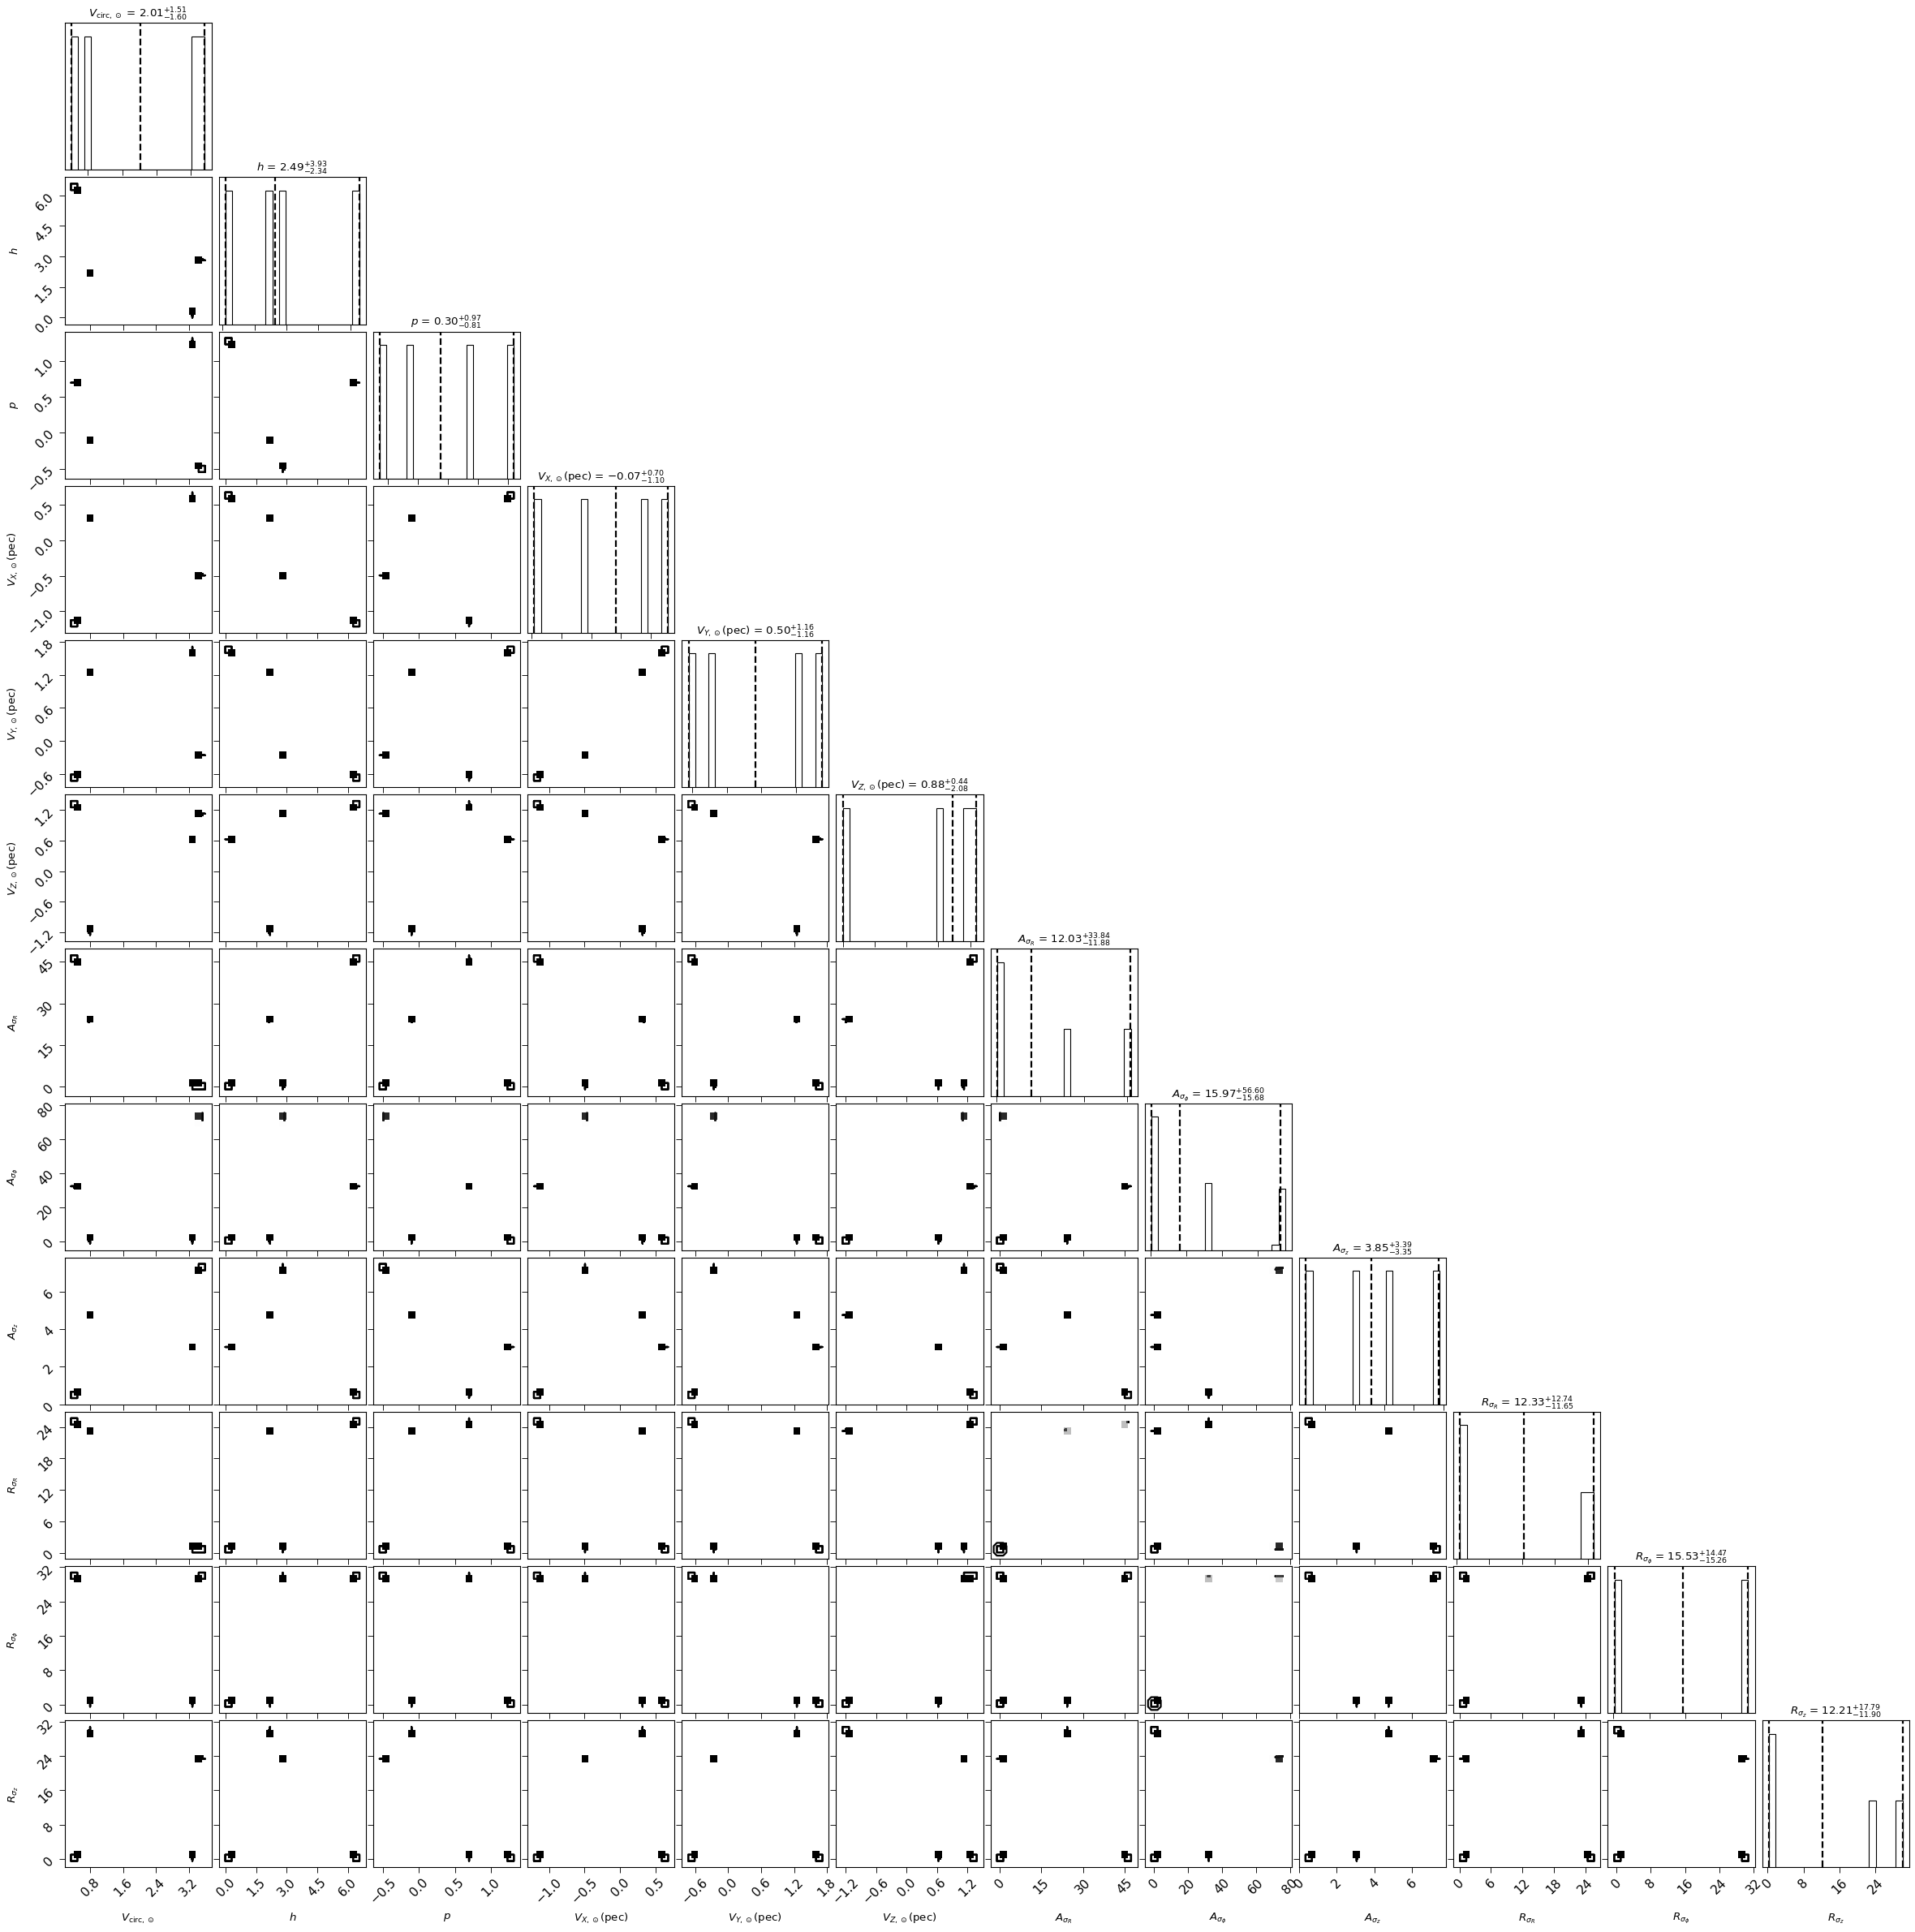

In [20]:
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")
    
sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']):
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()
                         
useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

## Sgr A* proper motion (assuming no intrinsic motion for this source) and Oort constants

In [22]:
sunpos = np.array([-Rsun.value, 0, zsun.value])*u.kpc
vsunpeculiar = np.array([stan_model['best_params']['Vsun_pec_x'], stan_model['best_params']['Vsun_pec_y'], stan_model['best_params']['Vsun_pec_z']])*u.km/u.s
vcircsun = stan_model['best_params']['Vcirc_sun']
hbp = stan_model['best_params']['hbp']
pbp = stan_model['best_params']['pbp']

diskmodel_best = DiskKinematicModel(BrunettiPfennigerRotationCurve(vcircsun, Rsun.value, hbp, pbp), sunpos, vsunpeculiar)

In [23]:
vsunx_samples = fgkm_fit.draws()[:,:,9].flatten()
vsuny_samples = fgkm_fit.draws()[:,:,10].flatten()+fgkm_fit.draws()[:,:,7].flatten()
vsunz_samples = fgkm_fit.draws()[:,:,11].flatten()
vsunvec_samples = np.vstack([vsunx_samples, vsuny_samples, vsunz_samples])

vcircsun_samples = fgkm_fit.draws()[:,:,7].flatten()
h_samples = fgkm_fit.draws()[:,:,8].flatten()
p_samples = fgkm_fit.draws()[:,:,9].flatten()

ra_sgr = (17.0+45.0/60.0+40.0409/3600.0)*15
dec_sgr = -29 - 28.118/2300
l_sgr, b_sgr = ct.transform_sky_coordinates(np.deg2rad(ra_sgr), np.deg2rad(dec_sgr))
print(np.rad2deg(l_sgr)-360, np.rad2deg(b_sgr))

p_sgr = np.array([-np.sin(l_sgr), np.cos(l_sgr), 0.0])
q_sgr = np.array([-np.sin(b_sgr)*np.cos(l_sgr), -np.sin(b_sgr)*np.sin(l_sgr), np.cos(b_sgr)])

mu_sgr_xy_samples = -np.dot(p_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value
mu_sgr_z_samples = -np.dot(q_sgr, vsunvec_samples)/(Rsun*au_km_year_per_sec).value
mu_sgr_xy = np.median(mu_sgr_xy_samples)
mu_sgr_xy_rse = rse(mu_sgr_xy_samples)
mu_sgr_z = np.median(mu_sgr_z_samples)
mu_sgr_z_rse = rse(mu_sgr_z_samples)

print(f"mu_sgr_xy = {mu_sgr_xy:.2f}  +/- {mu_sgr_xy_rse:.3f}")
print(f"mu_sgr_z = {mu_sgr_z:.2f}  +/- {mu_sgr_z_rse:.3f}")

oortA_samples, oortB_samples = BrunettiPfennigerRotationCurve.oort_ab_static(Rsun.value, vcircsun_samples, h_samples, p_samples)
oortAminB_samples = oortA_samples - oortB_samples
oortA = np.median(oortA_samples)
oortA_rse = rse(oortA_samples)
oortB = np.median(oortB_samples)
oortB_rse = rse(oortB_samples)
oortAminB = np.median(oortAminB_samples)
oortAminB_rse = rse(oortAminB_samples)

print(f"Oort A = {oortA:.2f}  +/- {oortA_rse:.3f}")
print(f"Oort B = {oortB:.2f}  +/- {oortB_rse:.3f}")
print(f"Oort A-B = {oortAminB:.2f}  +/- {oortAminB_rse:.3f}")

-0.05951722261414716 -0.04846468783278978
mu_sgr_xy = -0.05  +/- 0.046
mu_sgr_z = -0.01  +/- 0.023
Oort A = 0.06  +/- 0.090
Oort B = -0.12  +/- 0.110
Oort A-B = 0.24  +/- 0.147


## Model check through predictive posterior

In [24]:
idata = az.from_cmdstanpy(
    posterior=fgkm_fit,
    posterior_predictive=['pred_pml', 'pred_pmb'],
    observed_data={'pml_obs': fgkm_data['pml_obs'],
                   'pmb_obs': fgkm_data['pmb_obs']},
    coords={'nsources': np.arange(fgkm_data['N'])},
    dims={
        'pml_obs': ['nsources'],
        'pmb_obs': ['nsources'],
        'pred_pml': ['nsources'],
        'pred_pmb': ['nsources'],
    },
)

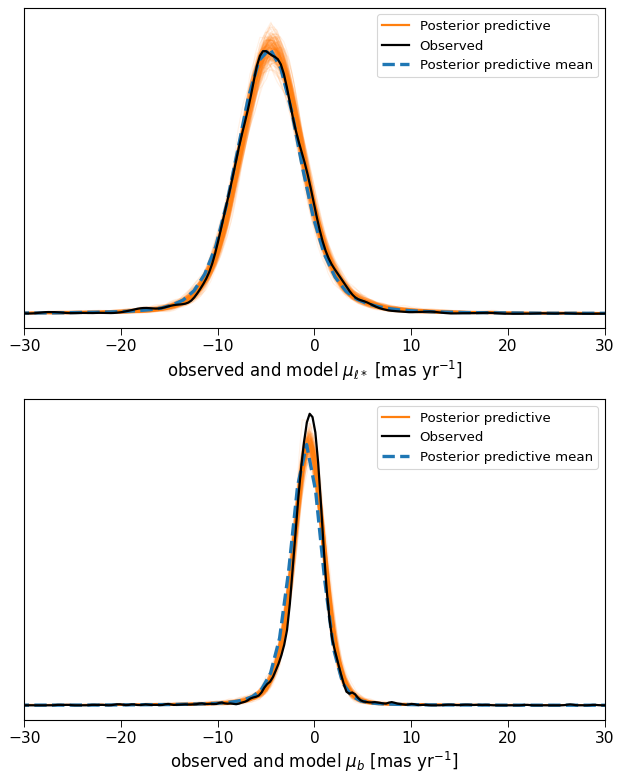

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(8, 2*5), tight_layout=True)
az.plot_ppc(idata, ax=axes, data_pairs={'pml_obs':'pred_pml', 'pmb_obs':'pred_pmb'}, 
            num_pp_samples=200, alpha=0.1, colors=['C1', 'k', 'C0'])
for ax in axes:
    ax.legend(fontsize=12)
    #apply_tufte(ax)
axes[0].set_xlim(-30,30)
axes[1].set_xlim(-30,30)
axes[0].set_xlabel(r'observed and model $\mu_{\ell*}$ [mas yr$^{-1}$]')
axes[1].set_xlabel(r'observed and model $\mu_b$ [mas yr$^{-1}$]')

plt.savefig('fgkmstars_pms_posterior_predictive.png')

plt.show()

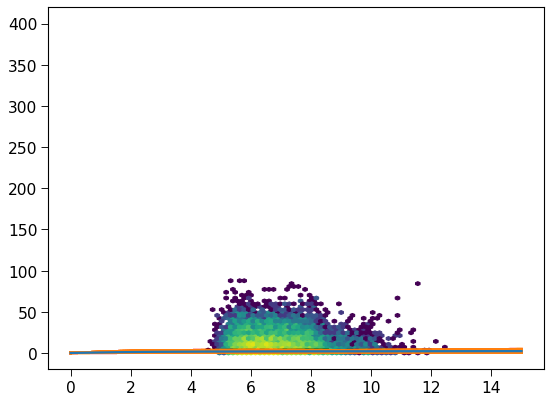

In [25]:
icrs_coords = ICRS(
    ra=(fgkmtable['ra'][hasrvs].data * u.deg).to(u.rad),
    dec=(fgkmtable['dec'][hasrvs].data * u.deg).to(u.rad),
    distance=(1000 / fgkmtable['parallax'][hasrvs].data) * u.pc,
    pm_ra_cosdec=fgkmtable['pmra'][hasrvs].data * u.mas / u.yr,
    pm_dec=fgkmtable['pmdec'][hasrvs].data * u.mas / u.yr,
    radial_velocity=fgkmtable['radial_velocity'][hasrvs].data * u.km / u.s,
)

_, _, gc_cyl = transform_to_galactic(
    icrs_coords,
    galcendist=Rsun,
    sunheight=zsun,
    vcircsun=vcircsun*u.km/u.s,
    vsunpec=vsunpeculiar,
)

rotcur = lambda x, h, p : x/h * np.power(1+(x/h)**2, (p-2)/4)

fig, axvphi = plt.subplots(1, 1, figsize=(8,6))

vphi_from_fit = -(gc_cyl.d_phi.to(u.rad / u.yr) / u.rad * gc_cyl.rho).to(u.km / u.s)

axvphi.hexbin(gc_cyl.rho.to(u.kpc), vphi_from_fit, mincnt=1, bins='log', extent=[0,15,0,400])

rcyl = np.linspace(0,15,1000)

inds = np.random.choice(p_samples.size, size=200, replace=False)
for i in inds:
    v0 = vcircsun_samples[i]/rotcur(Rsun.value, h_samples[i], p_samples[i])
    axvphi.plot(rcyl, v0*rotcur(rcyl, h_samples[i], p_samples[i]), c='C1', alpha=0.1)

v0 = vcircsun/rotcur(Rsun.value, hbp, pbp)
axvphi.plot(rcyl, v0*rotcur(rcyl, hbp, pbp), c='C0', lw=2)

plt.show()

In [21]:
icrs_coords = ICRS(
    ra=(fgkmtable['ra'][hasrvs].data * u.deg).to(u.rad),
    dec=(fgkmtable['dec'][hasrvs].data * u.deg).to(u.rad),
    distance=(1000 / fgkmtable['parallax'][hasrvs].data) * u.pc,
    pm_ra_cosdec=fgkmtable['pmra'][hasrvs].data * u.mas / u.yr,
    pm_dec=fgkmtable['pmdec'][hasrvs].data * u.mas / u.yr,
    radial_velocity=fgkmtable['radial_velocity'][hasrvs].data * u.km / u.s,
)

_, _, gc_cyl = transform_to_galactic(
    icrs_coords,
    galcendist=Rsun,
    sunheight=zsun,
    vcircsun=vcircsun*u.km/u.s,
    vsunpec=vsunpeculiar,
)

rotcur = lambda x, h, p : x/h * np.power(1+(x/h)**2, (p-2)/4)

fig, axvphi = plt.subplots(1, 1, figsize=(8,6))

vphi_from_fit = -(gc_cyl.d_phi.to(u.rad / u.yr) / u.rad * gc_cyl.rho).to(u.km / u.s)

axvphi.hexbin(gc_cyl.rho.to(u.kpc), vphi_from_fit, mincnt=1, bins='log', extent=[0,15,0,400])

rcyl = np.linspace(0,15,1000)

inds = np.random.choice(p_samples.size, size=200, replace=False)
for i in inds:
    v0 = vcircsun_samples[i]/rotcur(Rsun.value, h_samples[i], p_samples[i])
    axvphi.plot(rcyl, v0*rotcur(rcyl, h_samples[i], p_samples[i]), c='C1', alpha=0.1)

v0 = vcircsun/rotcur(Rsun.value, hbp, pbp)
axvphi.plot(rcyl, v0*rotcur(rcyl, hbp, pbp), c='C0', lw=2)

plt.show()

NameError: name 'vcircsun' is not defined

## Compare model predictions and observations in the proper motion vs longitude plots

2750.0288243656014


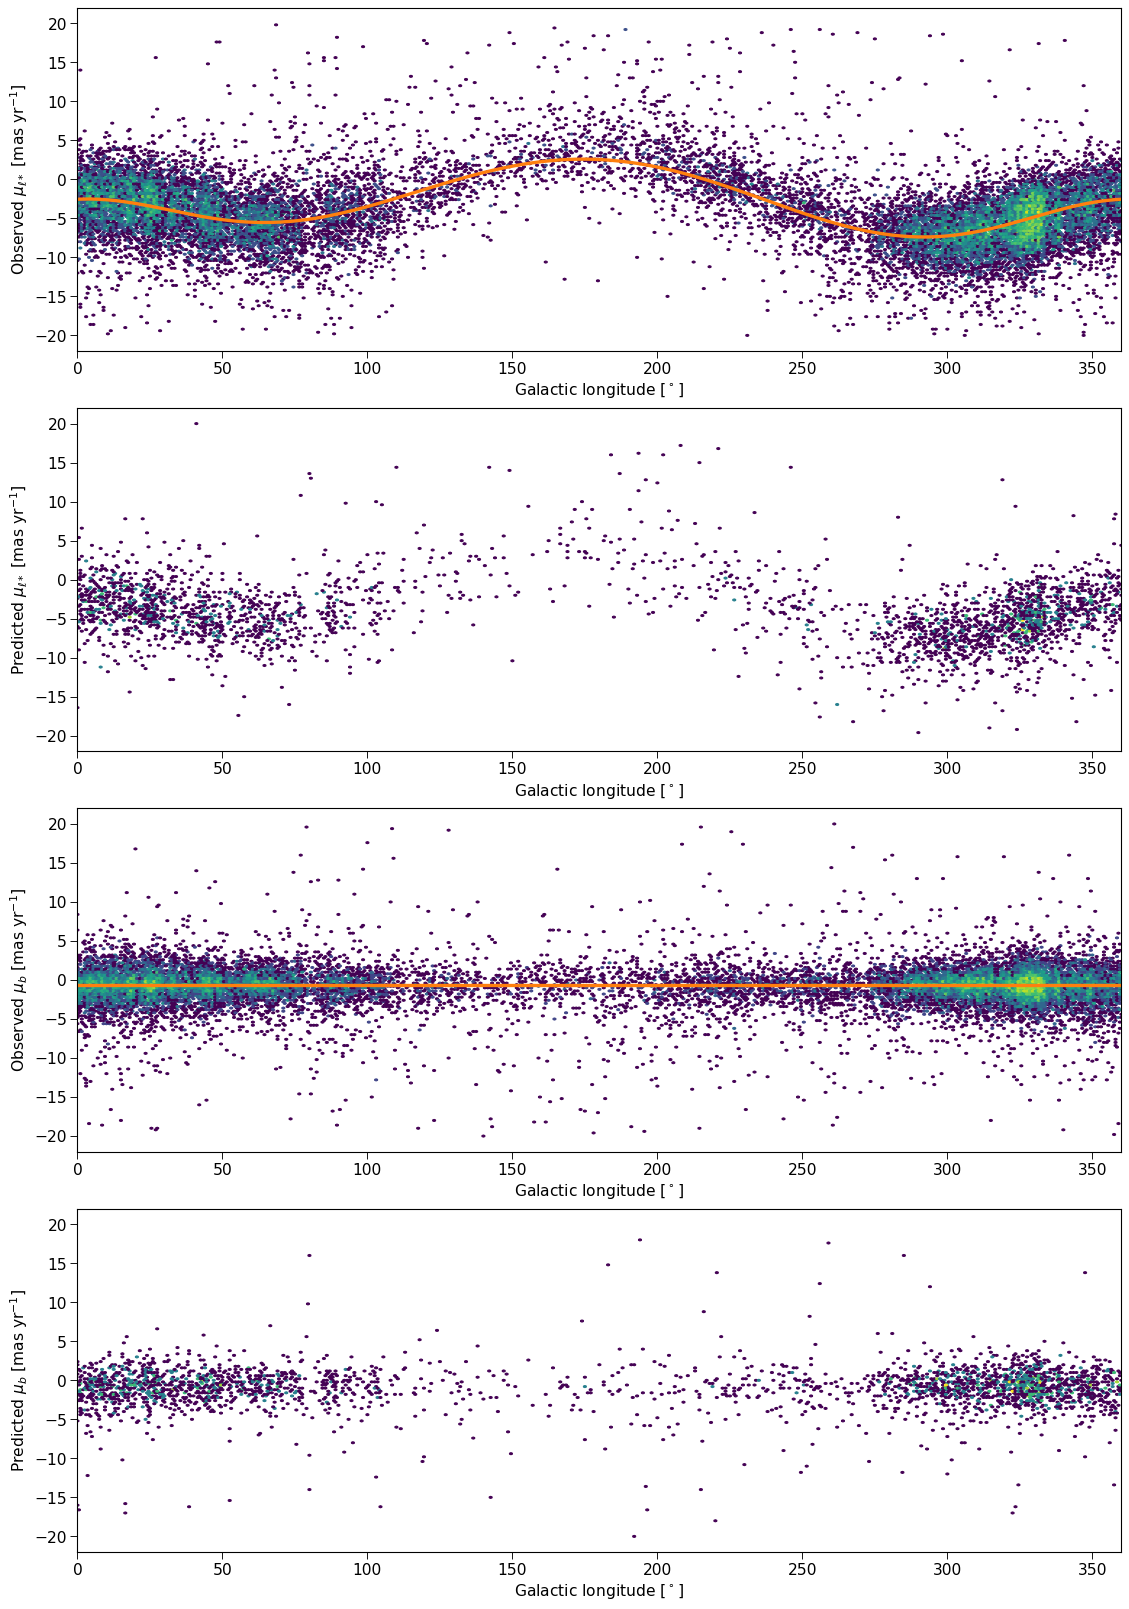

In [27]:
galon = np.linspace(0,360,361)*u.deg

median_dist = 1000/np.median(fgkmtable['parallax'][sample_filter])
print(median_dist)

chain = np.random.choice(nchains)
mcsample = np.random.choice(nsampling)

fig=plt.figure(constrained_layout=True, figsize=(14,4*5))

gs = GridSpec(4, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'Observed $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmul_model = fig.add_subplot(gs[1,0])
im_lmul_model = ax_lmul_model.hexbin(fgkm_subsample['l'], idata.posterior_predictive['pred_pml'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul_model.set_ylabel(r'Predicted $\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul_model.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[2,0])
im_lmub = ax_lmub.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'Observed $\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

ax_lmub_model = fig.add_subplot(gs[3,0])
im_lmub_model = ax_lmub_model.hexbin(fgkm_subsample['l'], idata.posterior_predictive['pred_pmb'][chain, mcsample, :], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub_model.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub_model.set_ylabel(r'Predicted $\mu_b$ [mas yr$^{-1}$]')
ax_lmub_model.set_xlim(0,360)

for dist in [median_dist]:
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel_best.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, c='C1', lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, c='C1', lw=3)

plt.show()

## Overplot model predictions for specific distances on observed proper motions

2750.0288243656014


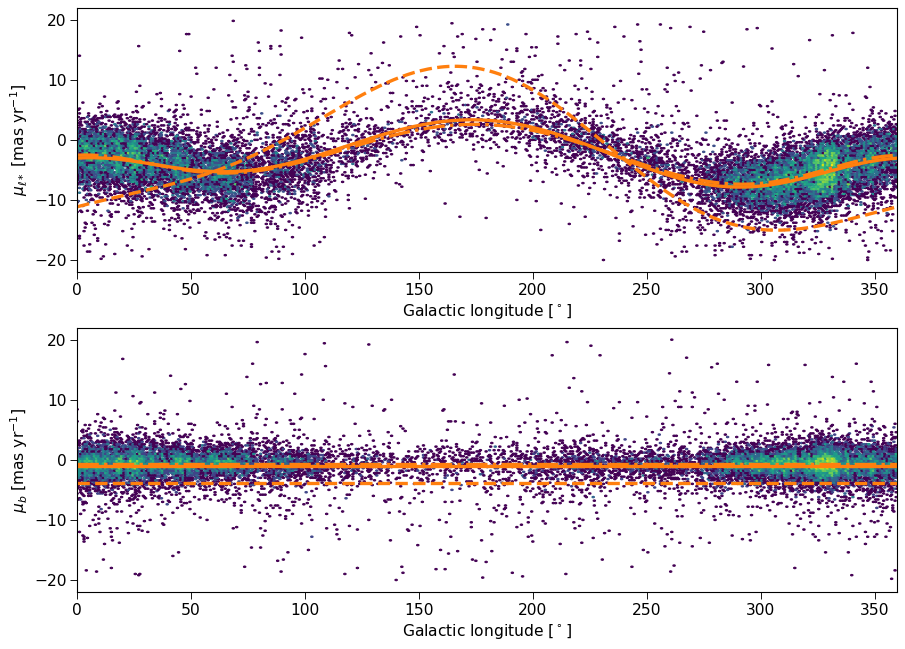

In [28]:
fig=plt.figure(constrained_layout=True, figsize=(0.8*14,0.8*10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(fgkmtable['l'][sample_filter], fgkmtable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20])
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

print(median_dist)
for dist, lstyle in zip([500, median_dist, 2000], ['--C1', '-.C1', '-C1']):
    distance = np.zeros_like(galon.value) + dist*u.pc
    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
    pml_model, pmb_model, vrad_model = diskmodel_best.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, lstyle, lw=3, label=rf'$d={dist:.0f}$ pc')
    ax_lmub.plot(galon, pmb_model, lstyle, lw=3)

plt.savefig('fgkmstar-pml-pmb-vs-galon-plusmodel.png')

plt.show()